In [4]:
#!git clone https://github.com/giojaz911/Recognition-and-classification-YOLO-.git hola

Cloning into 'hola'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18 (delta 4), reused 15 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 1.16 MiB | 8.54 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
!pip install -r ./hola/requirements.txt

In [18]:

#! Todos los Imports del proyecto
from ultralytics import YOLO
import shutil
import getpass
import sys
import time
import os
import zipfile
import pandas as pd
from collections import Counter
import subprocess

In [9]:
#? Variables importantes para el módelo.

dataset_id = 'giovanijazin/birds-penguins-and-flamingo'
zip_filename = 'birds-penguins-and-flamingo.zip'
dataset_name = 'birds-penguins-and-flamingo'
yaml_path = "./datasets/birds-penguins-and-flamingo/data.yaml"

<h1>Funciones para la configuración de entornos y rutas del sistema</h1>

Configuración de entornos y rutas del sistema en esta parte nos enfocaremos en la configuración de los entornos de <span style="color: orange;">collab</span> y <span style="color:skyblue;">local</span>, siendo estos la estructura en la que nuestro proyecto se desarrollará.

In [10]:

def enviroment_detector():
    """
    Esta función detecta en que entorno
    se está ejecutando sea en un entorno de collab o en local
    """

    if 'COLAB_GPU' in os.environ or 'google.colab' in str(get_ipython()):
        return 'colab'
    else:
        return 'local'


def path_builder(zip_filename: str, dataset_name: str):
    """
    Esta función se encarga de construir y remapear las rutas
    del proyecto en función del entorno en el que se está ejecutando.
    Args:
        zip_filename (str): Nombre del archivo ZIP descargado
        dataset_name (str): Nombre de la carpeta del dataset.

    Returns:
        str: La ruta base del dataset descomprimido.
    """

    enviroment = enviroment_detector()
    dataset_base_dir = 'datasets'

    if enviroment == 'colab':
        base_dir = '/content'
    else:
        base_dir = os.getcwd()

    zip_path = os.path.join(base_dir, zip_filename)
    extract_path = os.path.join(base_dir, dataset_base_dir, dataset_name)

    print(f"Entorno: {enviroment}")
    print(f"Ruta de extracción: {extract_path}")

    #? Comprueba si existen los directorios base y sino, los crea.

    if not os.path.exists(extract_path):
        os.makedirs(extract_path, exist_ok=True)

    #? Comprueba s el archivo zip existe
    if os.path.exists(zip_path):
        #? Comprueba si el archivo fue descomprimido.
        if not os.path.exists(os.path.join(extract_path, "train/images")):
            print("Descomprimiendo el archivo zip...")
            try:
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(extract_path)
                print("Archivo zip descomprimido exitosamente.")
            except Exception as e:
                print(f"Error al descomprimir el archivo zip: {e}")
        else:
            print("El archivo zip ya ha sido descomprimido.")
    else:
        print(f"El archivo'{zip_filename}'no existe en' {base_dir}")


    return extract_path




Configuración de la API nde Kaggle en base al entorno de ejecución y el sistema operativo.

In [11]:


def kaggle_setup(file_name: str = 'kaggle.json'):
    """
    Esta función se encargar de configurar, subir,
    mover la API conseguida en Kaggle.

    """

    enviroment = enviroment_detector()
    kaggle_dir = os.path.join(os.path.expanduser('~'), '.kaggle')
    dest_file = os.path.join(kaggle_dir, file_name)

    if not os.path.exists(kaggle_dir):
        os.makedirs(kaggle_dir, exist_ok=True)

    if os.path.exists(dest_file):
        print(f"El archivo '{file_name}'ya existe.")
        return

    if enviroment == 'colab':
        print("El enviroment en uso es Colab")
        try:
            from google.colab import files
            print("Por favor suba el archivo kaggle.json")
            uploaded = files.upload()

            if file_name in uploaded:
                shutil.move(file_name, dest_file)
                print(f"Archivo '{file_name}' subido y movido exitosamente. in {dest_file}")
            else:
                print(f"Archivo selecionado es incorrecto.")
        except ImportError:
            print("No se pudo usar el arhivo. Intenta la configuración manual.")

    else:
        print("El enviroment en uso es local")
        source_file = os.path.join(os.getcwd(), file_name)

        if os.path.exists(source_file):
            try:
                shutil.copy2(source_file, dest_file)
                print(f"El archivo '{file_name}' copiado con éxito")
            except Exception as e:
                print(f"Error al copiar el archivo '{file_name}': {str(e)}")
                return
        else:
            print(f"Error el archivo '{file_name}' no fue encontrado. \n Por favor colocar el archivo en {os.getcwd()}")

        #? Si el sistenma operativo no es Windows
        if os.name != 'nt':
            os.chmod(dest_file, 0o600)

In [12]:
kaggle_setup()

El enviroment en uso es Colab
Por favor suba el archivo kaggle.json


Saving kaggle.json to kaggle.json
Archivo 'kaggle.json' subido y movido exitosamente. in /root/.kaggle/kaggle.json


In [24]:
from IPython.utils.capture import capture_output
from kaggle.api.kaggle_api_extended import KaggleApi

def dataset_request(dataset_request_id: str, zip_filename: str):
    """
    Esta función hace la solicitud del dataset de Kaggle y descarga el zip.

    Args:
        dataset_request_id(str): El identificador del dataset (ej. 'giovanijazin/birds-penguins-and-flamingo')
        zip_filename (str): Nombre del archivo ZIP esperado (ej. 'birds-penguins-and-flamingo.zip').
    """

    print("Descargando el dataset...")
    try:
        api = KaggleApi()
        api.authenticate()

        api.dataset_download_files(dataset_request_id)
        print(f"Dataset '{zip_filename}' descargado correctamente.")
    except Exception as e_api:
        print(f"ERROR: No se pudo descargar el dataset '{zip_filename}' a través de API. \n Intentando a través de comandos.")

        try:
            download_command = ['kaggle', 'datasets', 'download', dataset_request_id, '-o']
            #os.system(f"kaggle datasets download -d {dataset_request_id}") alternativa de momento.
            subprocess.run(download_command,
                            check = True,
                            capture_output= True,
                            text=True
                            )
            print(f"Descarga completada del dataset '{zip_filename}' usando el comando '{download_command}'")
        except FileNotFoundError:
            print(f"ERROR: No se encontró el comando Kaggle por favor instala (pip install kaggle)")
        except subprocess.CalledProcessError as e_cmd:
            print(f"Error de Comando: Por favor revisa las credenciales o el nombre del Dataset")
            print(f"Salida de Error: {e_cmd.stderr}")

        except Exception as e_cmd_gen:
            print(f"ERROR DESCONOCIDO al usar el comando de terminal: {e_cmd_gen}")

    if os.path.exists(zip_filename):
        print("Dataset descargado correctamente.")
    else:
        print(f"ERROR: El archivo '{zip_filename}' no se encontró. Verifica las credenciales de Kaggle y la ruta.")
    if zip_filename == 'Twice-One-In-A-Million.zip':
        print("""⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀
⣠⣴⢟⣶⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣀⣴⣾⠀⠀⠀⠀⠀
⠀⠾⠋⠙⠂⢀⣠⣴⣶⣶⣶⣾⣿⣿⣟⣹⣾⠇⠀⠀⠀⠀⠀
⠀⠀⠀⢠⣶⣿⠿⠿⣿⣿⢿⡻⢿⡟⠿⠟⠁⠀⠀⠀⠀⠀⠀
⠀⠀⣰⡟⠁⠀⠀⣸⣿⣿⡿⠀⠀⠀⠀⠀⣀⡀⢀⡀⠀⠀⠀
⠀⢰⣿⡅⠀⠀⠀⣾⣿⣷⠁⠀⠀⠀⠀⢿⣿⣿⣮⣿⠂⠀⠀
⠀⢸⣿⣿⣄⠀⢠⣿⣿⠇⢠⣿⣿⣿⡄⠀⣿⣿⡏⠀⠀⠀⠀
⠀⠈⠛⠋⠀⠀⢸⣿⣿⠀⢾⣿⢩⣿⠇⠀⣿⣿⠏⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠸⣿⣿⡀⠘⣿⣾⠏⠁⣰⣿⡟⠀⠀⢀⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠙⠿⣿⡶⠟⢿⣶⣾⡿⠋⠀⣯⠚⢹⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠉⠲⡴⠊⠁
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀""")

In [22]:
dataset_request(dataset_id, zip_filename)

Descargando el dataset...
ERROR: No se pudo descargar el dataset 'birds-penguins-and-flamingo.zip' a través de API. 
 Intentando a través de comandos.
Descarga completada del dataset 'birds-penguins-and-flamingo.zip' usando el comando '['kaggle', 'datasets', 'download', 'giovanijazin/birds-penguins-and-flamingo', '-o']'
Dataset descargado correctamente.


In [23]:
path_builder(zip_filename, dataset_name)

Entorno: colab
Ruta de extracción: /content/datasets/birds-penguins-and-flamingo
Descomprimiendo el archivo zip...
Archivo zip descomprimido exitosamente.


'/content/datasets/birds-penguins-and-flamingo'

<H2>Estructuración YOLO </H2>

En este apartado configuramos el <span style="color:red">data.yaml</span> el cual será fundamental para la estructura de nuestros modelos.


In [ ]:
import yaml

data = {
    'path': './datasets/birds-penguins-and-flamingo',
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'names': {
        0: 'Flamingo',
        1: 'Penguin'
    }
}

with open('./datasets/birds-penguins-and-flamingo/data.yaml', 'w') as file:
    yaml.dump(data, file,
              default_flow_style=False,
              sort_keys=False)

In [ ]:


# --- 1. CONFIGURACIÓN E INICIALIZACIÓN DE DATAFRAMES ---

# Nombres de los archivos donde se guardará la comparación de modelos
GLOBAL_FILE = 'yolo_comparacion_global.csv'
CLASE_FILE = 'yolo_comparacion_por_clase.csv'


def initialize_dfs():
    """Carga los DataFrames maestros si existen, o los crea con las columnas requeridas."""

    # Intenta cargar los DataFrames persistentes
    try:
        df_global = pd.read_csv(GLOBAL_FILE)
    except FileNotFoundError:
        # Crea el DataFrame Global si no existe
        df_global = pd.DataFrame(columns=[
            'Modelo_ID', 'mAP50', 'mAP50-95', 'Precision_Media', 'Recall_Medio'
        ])

    try:
        df_clase = pd.read_csv(CLASE_FILE)
    except FileNotFoundError:
        # Crea el DataFrame Por Clase si no existe
        df_clase = pd.DataFrame(columns=[
            'Modelo_ID', 'Class', 'Box-P', 'Box-R', 'Box-F1', 'mAP50', 'mAP50-95'
        ])

    return df_global, df_clase


# --- 2. FUNCIÓN DE EXTRACCIÓN Y EVALUACIÓN ---

def extraer_metricas_yolo(run_name: str, split_to_use: str = 'test') -> tuple:
    """
    Evalúa el modelo usando model.val() y estructura las métricas.
    """
    # Construir la ruta al mejor modelo
    model_path = os.path.join("runs", "detect", run_name, "weights", "best.pt")
    print(f"\n--- Evaluando modelo: {run_name} ({model_path}) ---")

    try:
        model = YOLO(model_path)
    except FileNotFoundError:
        print(f"ERROR: No se encontró el modelo en {model_path}.")
        return None, None

    # Ejecutar la Evaluación
    metrics = model.val(split=split_to_use,
                        verbose=False,
                        save = False)

    # A. EXTRACCIÓN GLOBAL
    global_summary = {
        'Modelo_ID': run_name,
        'mAP50': metrics.box.map50.item(),
        'mAP50-95': metrics.box.map.item(),
        'Precision_Media': metrics.box.mp.item(),
        'Recall_Medio': metrics.box.mr.item()
    }

    # B. EXTRACCIÓN POR CLASE
    list_clase_summary = []

    # Obtener los datos numéricos brutos
    P_cls = metrics.box.p.tolist()
    R_cls = metrics.box.r.tolist()
    ap50_cls = metrics.box.ap50.tolist()
    ap_mean_cls = metrics.box.all_ap.mean(axis=1).tolist()

    for cls_id, name in metrics.names.items():
        P, R = P_cls[cls_id], R_cls[cls_id]
        Box_F1 = 2 * (P * R) / (P + R) if (P + R) > 0 else 0.0

        clase_dict = {
            'Class': name,
            'Box-P': P,
            'Box-R': R,
            'Box-F1': Box_F1,
            'mAP50': ap50_cls[cls_id],
            'mAP50-95': ap_mean_cls[cls_id]
        }
        list_clase_summary.append(clase_dict)

   # print("✅ Métricas extraídas exitosamente.")
    return global_summary, list_clase_summary


# --- 3. FUNCIÓN DE AGREGACIÓN Y COMPARACIÓN ---

def agregar_metricas_a_comparador(run_name: str, split_to_use: str = 'test'):
    """
    Función principal: Evalúa un modelo y agrega sus resultados a los DataFrames maestros.
    """

    # Cargar los DataFrames maestros actualizados (asegurando persistencia)
    df_global_comparacion, df_clase_comparacion = _initialize_dfs()

    # Obtener las métricas del modelo actual
    global_summary, list_clase_summary = extraer_metricas_yolo(run_name, split_to_use)

    if global_summary is None:
        return df_global_comparacion, df_clase_comparacion

    # === A. PROCESAR Y AGREGAR RESUMEN GLOBAL ===

    # 1. Eliminar duplicado (si el modelo ya estaba)
    df_global_comparacion = df_global_comparacion[df_global_comparacion['Modelo_ID'] != run_name]

    # 2. Añadir la nueva fila (con pd.concat)
    nueva_fila_global = pd.Series(global_summary)
    df_global_comparacion = pd.concat([df_global_comparacion, nueva_fila_global.to_frame().T], ignore_index=True)

    # === B. PROCESAR Y AGREGAR RESUMEN POR CLASE ===

    # 1. Preparar el DataFrame de clases
    df_new_clases = pd.DataFrame(list_clase_summary)
    df_new_clases.insert(0, 'Modelo_ID', run_name) # Añadir el ID del modelo

    # 2. Eliminar filas viejas del modelo y añadir las nuevas filas
    df_clase_comparacion = df_clase_comparacion[df_clase_comparacion['Modelo_ID'] != run_name]
    df_clase_comparacion = pd.concat([df_clase_comparacion, df_new_clases], ignore_index=True)

    # === C. GUARDAR Y DEVOLVER RESULTADOS ===

    # Guardar los DataFrames actualizados en disco
    df_global_comparacion.to_csv(GLOBAL_FILE, index=False)
    df_clase_comparacion.to_csv(CLASE_FILE, index=False)

    print(f"\n✨ Comparación actualizada. Resultados guardados en {GLOBAL_FILE} y {CLASE_FILE}.")

    return df_global_comparacion, df_clase_comparacion

In [ ]:
# 1. Cargar el modelo (nano, el más pequeño)
inicio = time.time()
model = YOLO("yolo11n.pt")

# Afinar el modelo
baseline_n = model.train(data="./datasets/birds-penguins-and-flamingo/data.yaml",
                      epochs=10, # Número de iteraciones
                      imgsz=640, # Tamaño de las imágenes (máxima dimensión)
                      #batch = 32,
                     # patience = 5, Si en 5 épocas seguidas no mejora el mAP, para el entrenamiento
                      plots=True, # Guardar gráficos de entrenamiento
                      name = "baseline_n"
                      )
fin = time.time()

time_baseline_n = fin - inicio

Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./datasets/birds-penguins-and-flamingo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline_n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

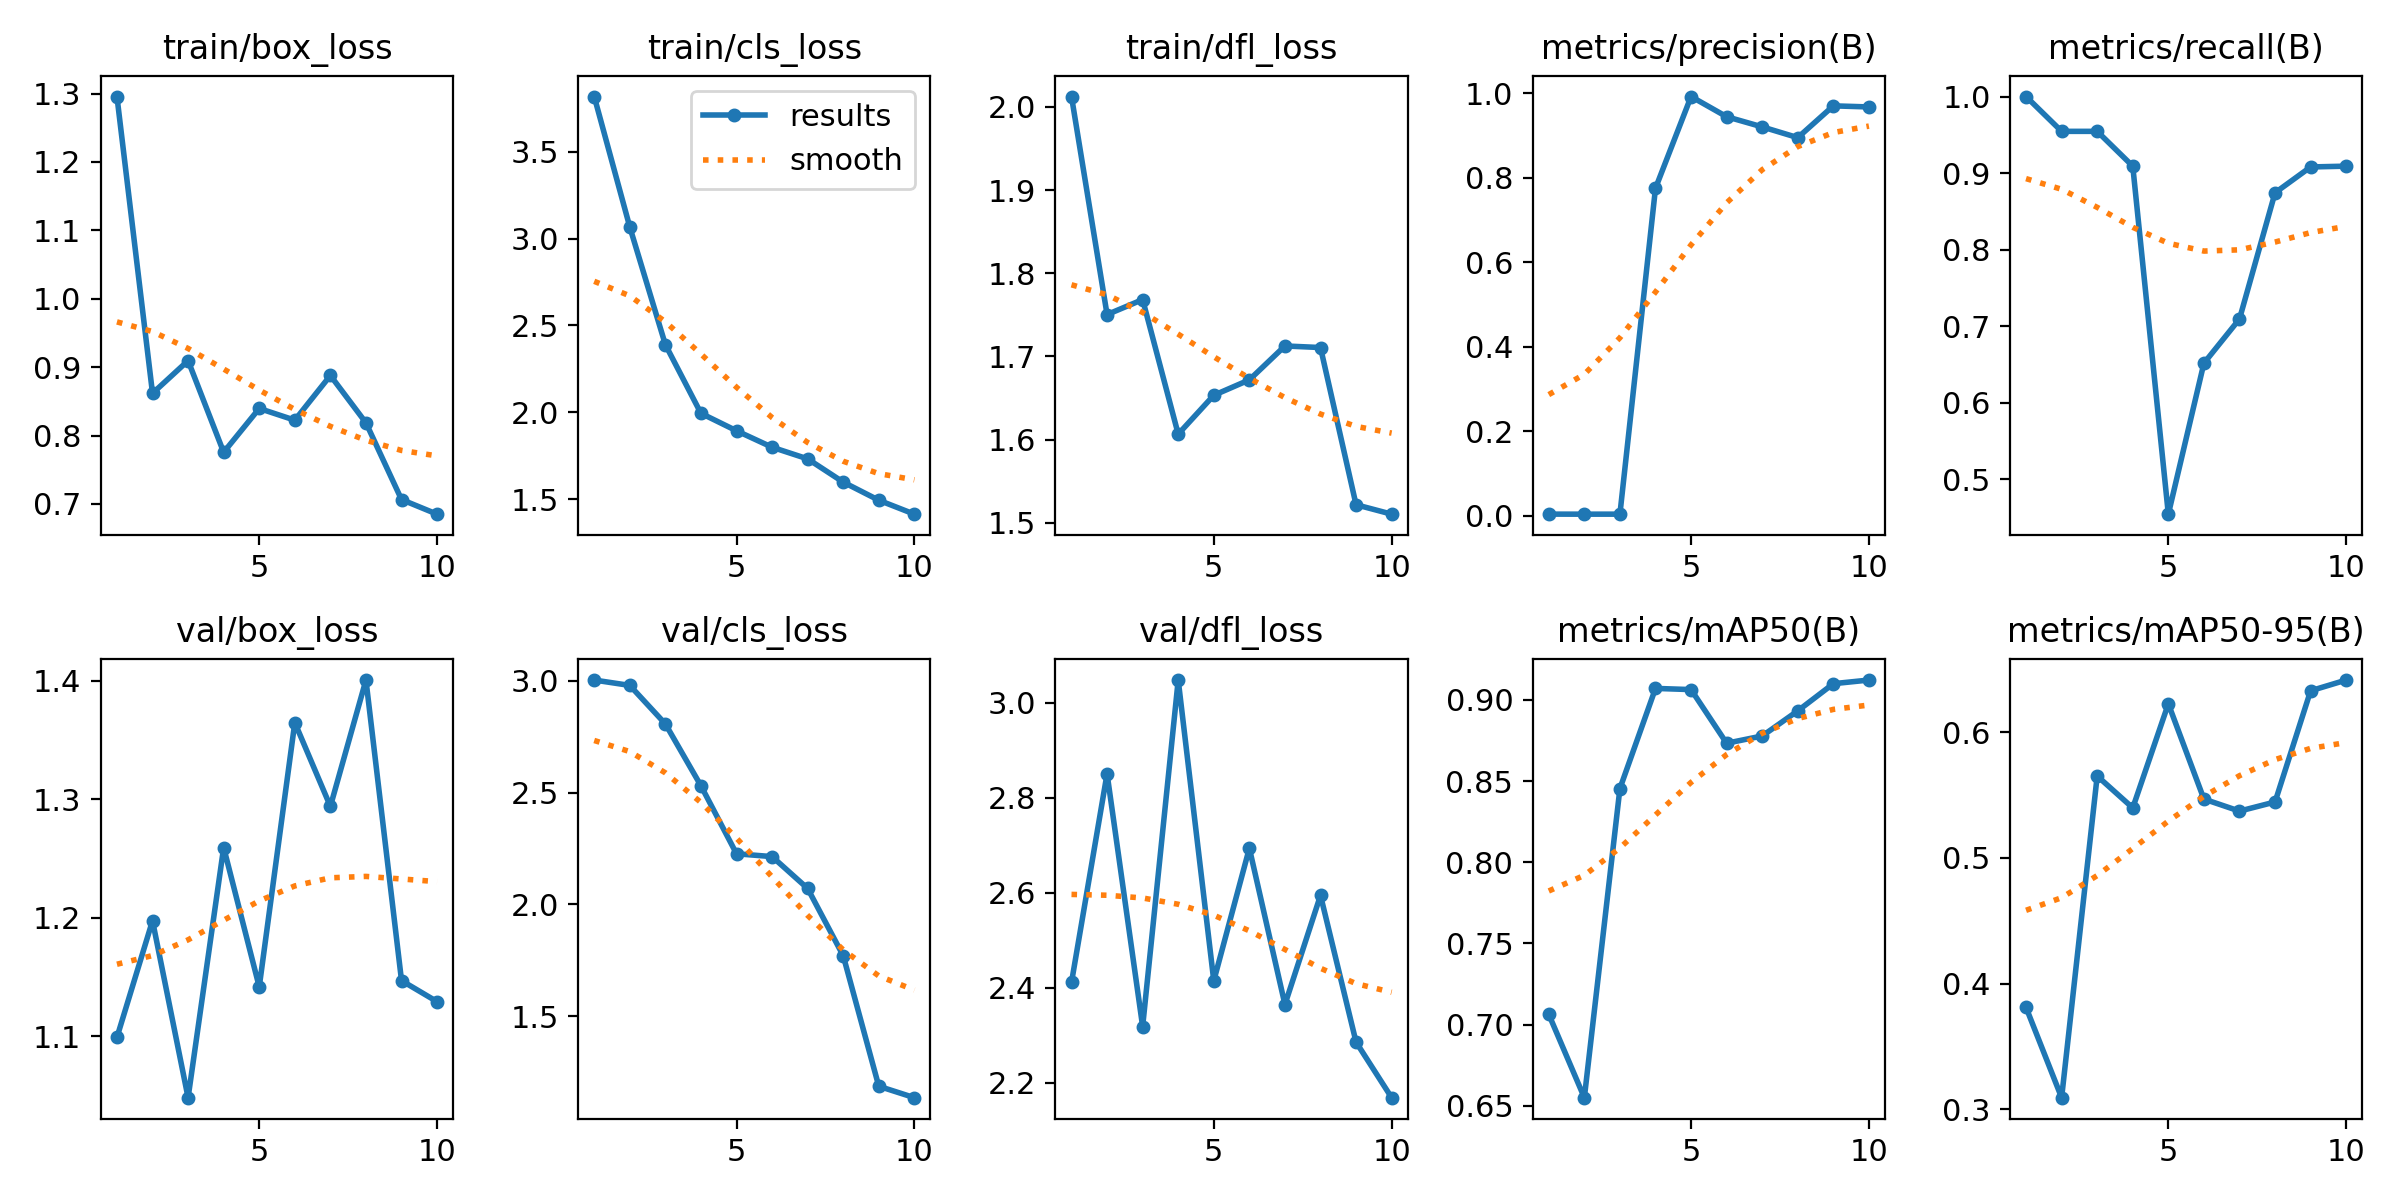

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename='./runs/detect/baseline_n/results.png', width=800)

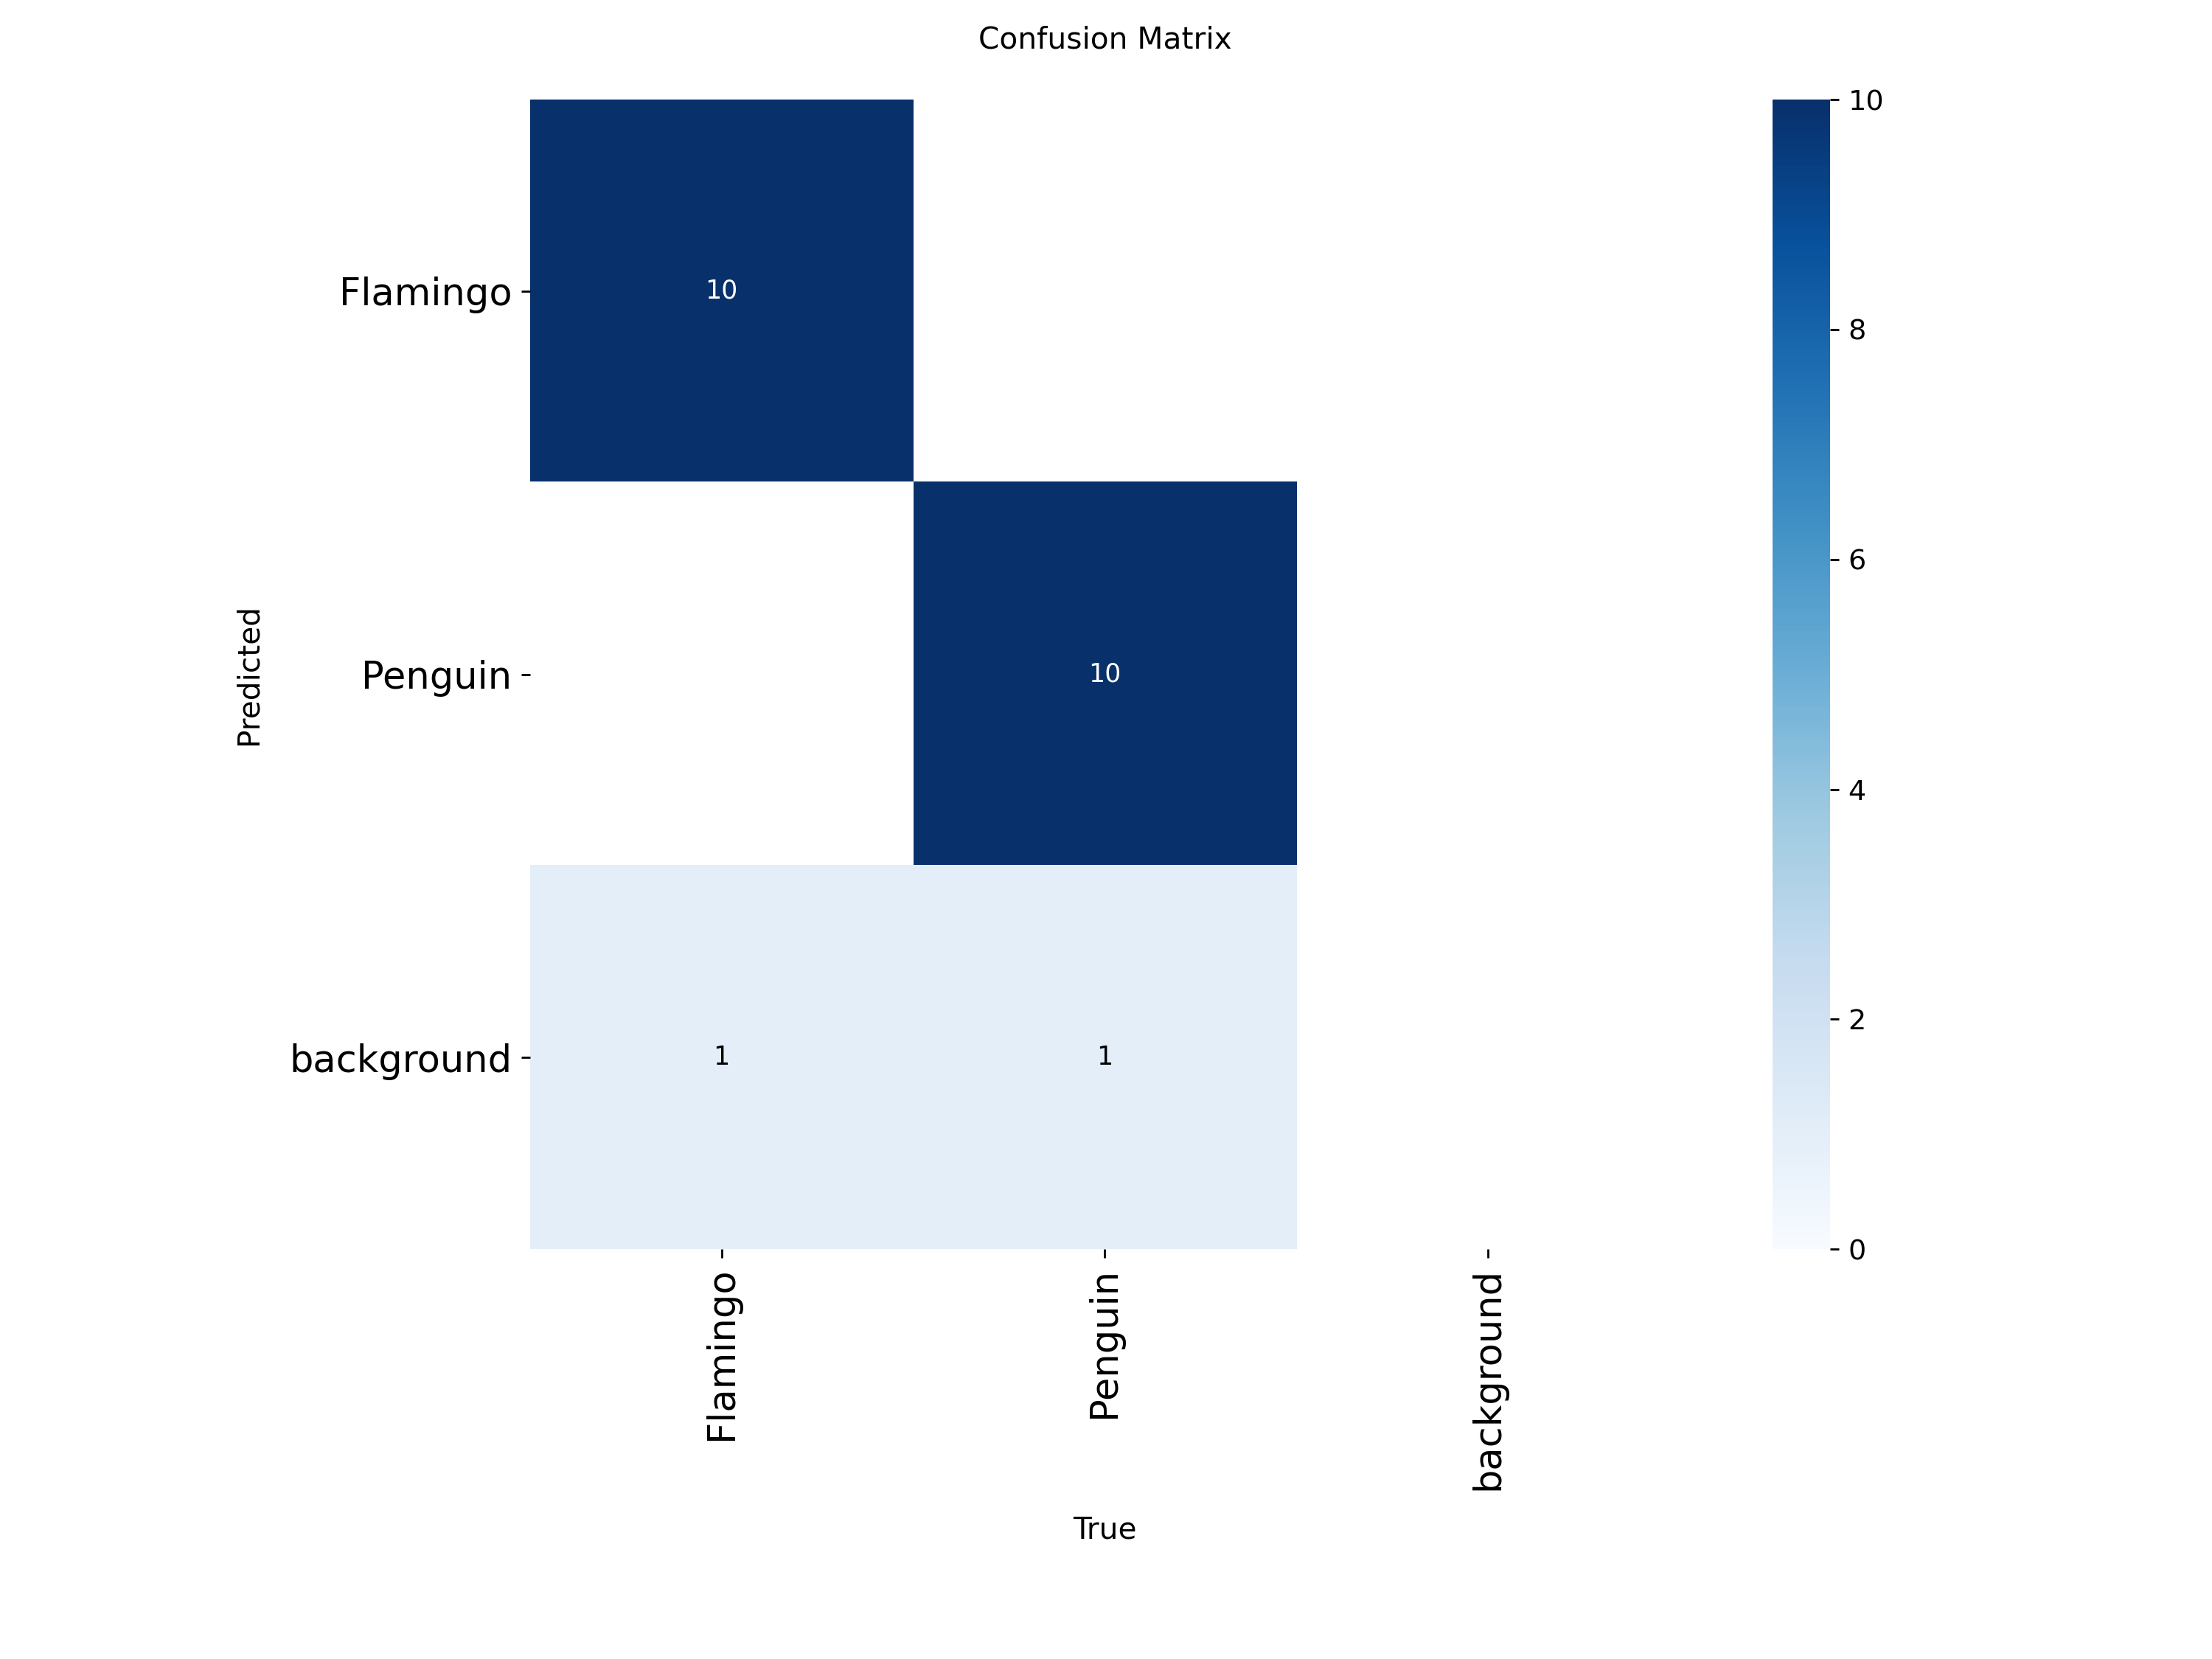

In [ ]:
IPyImage(filename='./runs/detect/baseline_n/confusion_matrix.png', width=600)

In [ ]:
model = YOLO('./runs/detect/baseline_n/weights/best.pt')
preds = model('./datasets/birds-penguins-and-flamingo/test/images')


image 1/10 /content/datasets/birds-penguins-and-flamingo/test/images/006_jpg.rf.b8ac5e1d3b6f751e043614f654681a18.jpg: 640x640 1 Flamingo, 7.8ms
image 2/10 /content/datasets/birds-penguins-and-flamingo/test/images/006_jpg.rf.da48b216a17c5299ddd5487e1a125fd8.jpg: 640x640 1 Penguin, 7.6ms
image 3/10 /content/datasets/birds-penguins-and-flamingo/test/images/014_jpg.rf.0a8bedf76aa9d3bdce579f868ac931b5.jpg: 640x640 1 Penguin, 8.2ms
image 4/10 /content/datasets/birds-penguins-and-flamingo/test/images/018_jpg.rf.35c95436f7a2c836aefd24f1157a7d7f.jpg: 640x640 1 Penguin, 7.3ms
image 5/10 /content/datasets/birds-penguins-and-flamingo/test/images/027_jpg.rf.abe289b6d8313ee28ba880f301019444.jpg: 640x640 1 Flamingo, 7.2ms
image 6/10 /content/datasets/birds-penguins-and-flamingo/test/images/029_jpg.rf.d0198ddff4f9b217429c52409d407f04.jpg: 640x640 1 Flamingo, 7.3ms
image 7/10 /content/datasets/birds-penguins-and-flamingo/test/images/034_jpg.rf.ce0579db7257276f6e23e6fcbea9a48f.jpg: 640x640 1 Flamingo, 

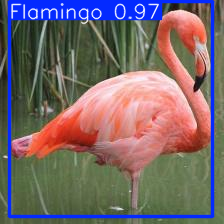

In [ ]:
import numpy as np
idx = np.random.randint(len(preds))
preds[idx].show()

In [ ]:
print(preds[2].boxes[0])

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1.], device='cuda:0')
conf: tensor([0.8423], device='cuda:0')
data: tensor([[ 25.7804,   1.9430, 220.3374, 223.0485,   0.8423,   1.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (224, 224)
shape: torch.Size([1, 6])
xywh: tensor([[123.0589, 112.4958, 194.5570, 221.1055]], device='cuda:0')
xywhn: tensor([[0.5494, 0.5022, 0.8686, 0.9871]], device='cuda:0')
xyxy: tensor([[ 25.7804,   1.9430, 220.3374, 223.0485]], device='cuda:0')
xyxyn: tensor([[0.1151, 0.0087, 0.9836, 0.9958]], device='cuda:0')


In [ ]:
UMBRAL_CONF = 0.7
boxes = [box for box in preds[0].boxes if box.conf > UMBRAL_CONF]
print(len(boxes))

1


In [ ]:
conteos = Counter([int(box.cls) for box in boxes])
conteos

Counter({0: 1})


Conteos:
Flamingo: 1


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

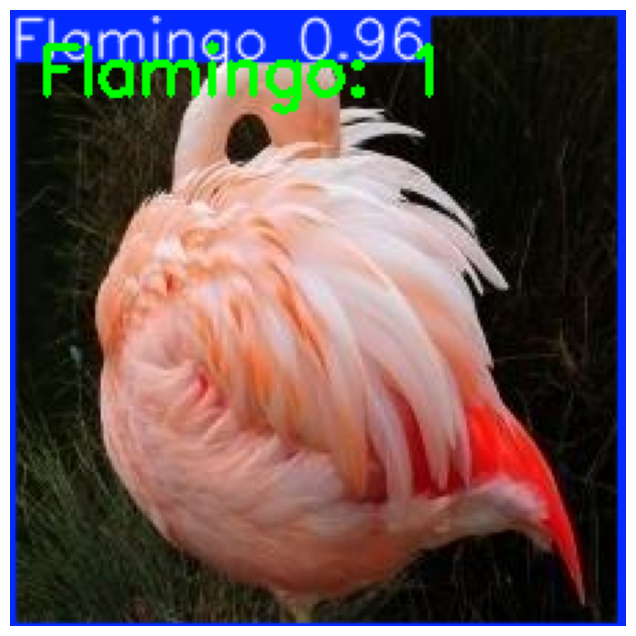

In [ ]:
import cv2 # OpenCV
import matplotlib.pyplot as plt

# Mapear categoría de objeto a nombres e imprimir conteos
nombres = model.names
print("\nConteos:")
for cls_id, num in conteos.items():
    print(f"{nombres[cls_id]}: {num}")


# Extraer imagen con los bounding boxes > UMBRAL_CONF
p = preds[0] # Predicción
mascara = p.boxes.conf > UMBRAL_CONF
p.boxes = p.boxes[mascara]
img_bboxes = p.plot() # Imagen con los bounding boxes filtrados

# Añadir anotación mostrando los conteos (esquina superior izquierda)
anotacion = ", ".join([f"{nombres[c]}: {n}" for c, n in conteos.items()])
cv2.putText(img_bboxes, anotacion, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
            0.8, (0, 255, 0), 2)

# Convertir imagen de BGR a RGB
img_bboxes_rgb = cv2.cvtColor(img_bboxes, cv2.COLOR_BGR2RGB)

# Y mostrarla
plt.figure(figsize=(12, 8))
plt.imshow(img_bboxes_rgb)
plt.axis("off")

In [ ]:
from collections import Counter
import cv2
import matplotlib.pyplot as plt

def mostrar_conteos(modelo, ruta_img, umbral=0.5):
    """
    Función simplificada para contar objetos en una imagen.
    1. Detecta (filtrando por confianza).
    2. Cuenta.
    3. Muestra el resultado.
    """
    # 1. Predicción con filtro automático de confianza (conf=umbral)
    # Esto hace que el modelo ignore las cajas con baja probabilidad
    resultados = modelo(ruta_img, conf=umbral, verbose=False)
    pred = resultados[0]

    # 2. Realizar el conteo
    # pred.boxes.cls es una lista con los IDs de los objetos encontrados (ej: [0, 0, 0])
    clases_encontradas = [int(c) for c in pred.boxes.cls]
    conteos = Counter(clases_encontradas)

    # 3. Imprimir resultados (Texto)
    print(f"\n--- Conteo de objetos (Confianza > {umbral}) ---")
    if not conteos:
        print("No se detectaron objetos con suficiente confianza.")

    for id_clase, cantidad in conteos.items():
        nombre_objeto = modelo.names[id_clase]
        print(f" -> {nombre_objeto}: {cantidad}")

    # 4. Mostrar imagen (Gráfico)
    # plot() dibuja las cajas que pasaron el filtro
    img_con_cajas = pred.plot()

    # Convertir de BGR (OpenCV) a RGB (Matplotlib) para que los colores se vean bien
    img_rgb = cv2.cvtColor(img_con_cajas, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

    return conteos

In [ ]:
import os

RUTA_TST = './datasets/birds-penguins-and-flamingo/test/images/'
rutas_imgs = [f for f in os.listdir(RUTA_TST) if f.endswith('.jpg')]
rutas_imgs

['006_jpg.rf.b8ac5e1d3b6f751e043614f654681a18.jpg',
 '034_jpg.rf.ce0579db7257276f6e23e6fcbea9a48f.jpg',
 '006_jpg.rf.da48b216a17c5299ddd5487e1a125fd8.jpg',
 '029_jpg.rf.d0198ddff4f9b217429c52409d407f04.jpg',
 '027_jpg.rf.abe289b6d8313ee28ba880f301019444.jpg',
 '049_jpg.rf.d4697efb88c0755b230056285548aefa.jpg',
 '050_jpg.rf.699e5da78e15d5778695e2d64053e0d7.jpg',
 '044_jpg.rf.db2dd323441e654dce5019624fb5b75c.jpg',
 '018_jpg.rf.35c95436f7a2c836aefd24f1157a7d7f.jpg',
 '014_jpg.rf.0a8bedf76aa9d3bdce579f868ac931b5.jpg']


--- Conteo de objetos (Confianza > 0.5) ---
 -> Flamingo: 1


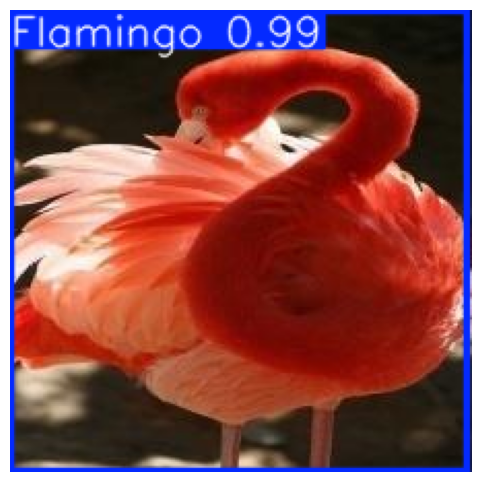

In [ ]:
conteo = mostrar_conteos(model, RUTA_TST + rutas_imgs[6])

In [ ]:
import pandas as pd
def cear_metricas(modelo:str):
  metrics_path = "./runs/detect/{modelo}/results.csv"
  df = pd.read_csv(df = pd.read_csv(metrics_path, sep=',', skipinitialspace=True))
  time = df["time"].sum()
  box_loss = df["test/box_loss"].mean()
  cls_loss = df["metrics/recall(B)"]

In [ ]:


# 1. Cargar el modelo (nano, el más pequeño)
model = YOLO("yolo11s.pt")
inicio = time.time()
# Afinar el modelo
baseline_s = model.train(data=yaml_path,
                      epochs=10, # Número de iteraciones
                      imgsz=640, # Tamaño de las imágenes (máxima dimensión)
                      #batch = 32,
                     # patience = 5, Si en 5 épocas seguidas no mejora el mAP, para el entrenamiento
                      plots=True, # Guardar gráficos de entrenamiento
                      name = "baseline_s"
                      )
fin = time.time()
time_baseline_s = fin - inicio

Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./datasets/birds-penguins-and-flamingo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline_s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

In [ ]:
baseline_n.summary()

[{'Class': 'Flamingo',
  'Images': np.int64(10),
  'Instances': np.int64(11),
  'Box-P': np.float64(0.99822),
  'Box-R': np.float64(0.90909),
  'Box-F1': np.float64(0.95157),
  'mAP50': np.float64(0.911),
  'mAP50-95': np.float64(0.60009)},
 {'Class': 'Penguin',
  'Images': np.int64(10),
  'Instances': np.int64(11),
  'Box-P': np.float64(0.93682),
  'Box-R': np.float64(0.90909),
  'Box-F1': np.float64(0.92275),
  'mAP50': np.float64(0.91346),
  'mAP50-95': np.float64(0.67763)}]

In [ ]:
baseline_s.summary()

[{'Class': 'Flamingo',
  'Images': np.int64(10),
  'Instances': np.int64(11),
  'Box-P': np.float64(0.9995),
  'Box-R': np.float64(0.81818),
  'Box-F1': np.float64(0.8998),
  'mAP50': np.float64(0.8969),
  'mAP50-95': np.float64(0.48589)},
 {'Class': 'Penguin',
  'Images': np.int64(10),
  'Instances': np.int64(11),
  'Box-P': np.float64(0.95954),
  'Box-R': np.float64(0.90909),
  'Box-F1': np.float64(0.93364),
  'mAP50': np.float64(0.9248),
  'mAP50-95': np.float64(0.63291)}]

In [ ]:


# --- 1. CONFIGURACIÓN E INICIALIZACIÓN DE DATAFRAMES ---

# Nombres de los archivos donde se guardará la comparación de modelos
GLOBAL_FILE = 'yolo_comparacion_global.csv'
CLASE_FILE = 'yolo_comparacion_por_clase.csv'


def initialize_dfs():
    """Carga los DataFrames maestros si existen, o los crea con las columnas requeridas."""

    # Intenta cargar los DataFrames persistentes
    try:
        df_global = pd.read_csv(GLOBAL_FILE)
    except FileNotFoundError:
        # Crea el DataFrame Global si no existe
        df_global = pd.DataFrame(columns=[
            'Modelo_ID', 'mAP50', 'mAP50-95', 'Precision_Media', 'Recall_Medio'
        ])

    try:
        df_clase = pd.read_csv(CLASE_FILE)
    except FileNotFoundError:
        # Crea el DataFrame Por Clase si no existe
        df_clase = pd.DataFrame(columns=[
            'Modelo_ID', 'Class', 'Box-P', 'Box-R', 'Box-F1', 'mAP50', 'mAP50-95'
        ])

    return df_global, df_clase


# --- 2. FUNCIÓN DE EXTRACCIÓN Y EVALUACIÓN ---

def extraer_metricas_yolo(run_name: str, split_to_use: str = 'test') -> tuple:
    """
    Evalúa el modelo usando model.val() y estructura las métricas.
    """
    # Construir la ruta al mejor modelo
    model_path = os.path.join("runs", "detect", run_name, "weights", "best.pt")
    print(f"\n--- Evaluando modelo: {run_name} ({model_path}) ---")

    try:
        model = YOLO(model_path)
    except FileNotFoundError:
        print(f"❌ ERROR: No se encontró el modelo en {model_path}.")
        return None, None

    # Ejecutar la Evaluación
    metrics = model.val(split=split_to_use,
                        verbose=False,
                        save = False)

    # A. EXTRACCIÓN GLOBAL
    global_summary = {
        'Modelo_ID': run_name,
        'mAP50': metrics.box.map50.item(),
        'mAP50-95': metrics.box.map.item(),
        'Precision_Media': metrics.box.mp.item(),
        'Recall_Medio': metrics.box.mr.item()
    }

    # B. EXTRACCIÓN POR CLASE
    list_clase_summary = []

    # Obtener los datos numéricos brutos
    P_cls = metrics.box.p.tolist()
    R_cls = metrics.box.r.tolist()
    ap50_cls = metrics.box.ap50.tolist()
    ap_mean_cls = metrics.box.all_ap.mean(axis=1).tolist()

    for cls_id, name in metrics.names.items():
        P, R = P_cls[cls_id], R_cls[cls_id]
        Box_F1 = 2 * (P * R) / (P + R) if (P + R) > 0 else 0.0

        clase_dict = {
            'Class': name,
            'Box-P': P,
            'Box-R': R,
            'Box-F1': Box_F1,
            'mAP50': ap50_cls[cls_id],
            'mAP50-95': ap_mean_cls[cls_id]
        }
        list_clase_summary.append(clase_dict)

   # print("✅ Métricas extraídas exitosamente.")
    return global_summary, list_clase_summary


# --- 3. FUNCIÓN DE AGREGACIÓN Y COMPARACIÓN ---

def agregar_metricas_a_comparador(run_name: str, split_to_use: str = 'test'):
    """
    Función principal: Evalúa un modelo y agrega sus resultados a los DataFrames maestros.
    """

    # Cargar los DataFrames maestros actualizados (asegurando persistencia)
    df_global_comparacion, df_clase_comparacion = initialize_dfs()

    # Obtener las métricas del modelo actual
    global_summary, list_clase_summary = extraer_metricas_yolo(run_name, split_to_use)

    if global_summary is None:
        return df_global_comparacion, df_clase_comparacion

    # === A. PROCESAR Y AGREGAR RESUMEN GLOBAL ===

    # 1. Eliminar duplicado (si el modelo ya estaba)
    df_global_comparacion = df_global_comparacion[df_global_comparacion['Modelo_ID'] != run_name]

    # 2. Añadir la nueva fila (con pd.concat)
    nueva_fila_global = pd.Series(global_summary)
    df_global_comparacion = pd.concat([df_global_comparacion, nueva_fila_global.to_frame().T], ignore_index=True)

    # === B. PROCESAR Y AGREGAR RESUMEN POR CLASE ===

    # 1. Preparar el DataFrame de clases
    df_new_clases = pd.DataFrame(list_clase_summary)
    df_new_clases.insert(0, 'Modelo_ID', run_name) # Añadir el ID del modelo

    # 2. Eliminar filas viejas del modelo y añadir las nuevas filas
    df_clase_comparacion = df_clase_comparacion[df_clase_comparacion['Modelo_ID'] != run_name]
    df_clase_comparacion = pd.concat([df_clase_comparacion, df_new_clases], ignore_index=True)

    # === C. GUARDAR Y DEVOLVER RESULTADOS ===

    # Guardar los DataFrames actualizados en disco
    df_global_comparacion.to_csv(GLOBAL_FILE, index=False)
    df_clase_comparacion.to_csv(CLASE_FILE, index=False)

    print(f"\n✨ Comparación actualizada. Resultados guardados en {GLOBAL_FILE} y {CLASE_FILE}.")

    return df_global_comparacion, df_clase_comparacion

In [ ]:
extraer_metricas_yolo("baseline_l", "test")


--- Evaluando modelo: baseline_l (runs/detect/baseline_l/weights/best.pt) ---
Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,280,854 parameters, 0 gradients, 86.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 436.7±201.2 MB/s, size: 8.0 KB)
val: Scanning /content/datasets/penguins-and-flamingos/test/labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 10/10 11.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 2.0it/s 0.5s
                   all         10         12      0.802      0.686      0.715      0.525
Speed: 1.8ms preprocess, 39.1ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/runs/detect/val12


({'Modelo_ID': 'baseline_l',
  'mAP50': 0.7151536661143332,
  'mAP50-95': 0.5254034094172881,
  'Precision_Media': 0.8017879886592375,
  'Recall_Medio': 0.6857142857142857},
 [{'Class': 'Flamingo',
   'Box-P': 0.9626785484465233,
   'Box-R': 0.8,
   'Box-F1': 0.8738324289882097,
   'mAP50': 0.8538235294117648,
   'mAP50-95': 0.6328921568627451},
  {'Class': 'Penguin',
   'Box-P': 0.6408974288719517,
   'Box-R': 0.5714285714285714,
   'Box-F1': 0.6041726435327789,
   'mAP50': 0.5764838028169015,
   'mAP50-95': 0.41791466197183097}])

In [ ]:
agregar_metricas_a_comparador("baseline_l", "test")
# 1. Ejecutar y CAPTURAR la salida:





--- Evaluando modelo: baseline_l (runs/detect/baseline_l/weights/best.pt) ---
Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,280,854 parameters, 0 gradients, 86.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 442.5±97.8 MB/s, size: 8.2 KB)
val: Scanning /content/datasets/penguins-and-flamingos/test/labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 10/10 12.4Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 1.9it/s 0.5s
                   all         10         12      0.802      0.686      0.715      0.525
Speed: 1.5ms preprocess, 37.3ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/runs/detect/val13

✨ Comparación actualizada. Resultados guardados en yolo_comparacion_global.csv y yolo_comparacion_por_clase.csv.

--- Evaluando modelo: baseline_l (runs/detect/baseline_l/weights

In [ ]:
initialize_dfs()

(    Modelo_ID     mAP50  mAP50-95  Precision_Media  Recall_Medio
 0  baseline_l  0.715154  0.525403         0.801788      0.685714,
     Modelo_ID     Class     Box-P     Box-R    Box-F1     mAP50  mAP50-95
 0  baseline_l  Flamingo  0.962679  0.800000  0.873832  0.853824  0.632892
 1  baseline_l   Penguin  0.640897  0.571429  0.604173  0.576484  0.417915)

In [ ]:
# 2. IMPRIMIR las variables CAPTURADAS:
df_global_final

,Modelo_ID,mAP50,mAP50-95,Precision_Media,Recall_Medio
0,baseline_l,0.715154,0.525403,0.801788,0.685714


In [ ]:


# 1. Cargar el modelo (nano, el más pequeño)
inicio = time.time()
model = YOLO("yolo11l.pt")

# Afinar el modelo
baseline_l = model.train(data=yaml_path,
                      epochs=10, # Número de iteraciones
                      imgsz=640, # Tamaño de las imágenes (máxima dimensión)
                      #batch = 32,
                     # patience = 5, Si en 5 épocas seguidas no mejora el mAP, para el entrenamiento
                      plots=True, # Guardar gráficos de entrenamiento
                      name = "baseline_l"
                      )
final = time.time()
beaseline_l_time = final - inicio

Ultralytics 8.3.237 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./datasets/birds-penguins-and-flamingo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=baseline_l, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

In [ ]:
print(beaseline_l_time)
print(time_baseline_s)
print(time_baseline_n)

160.2360622882843
63.53263759613037
68.56787610054016
